# Handle Imports

This is setup in a way that (hopefully) allows one to both run this notebook in Colab (Pro version) as well as locally if they have a beefy GPU.

In [1]:
try:
    import google.colab
    USING_COLAB = True
except:
    USING_COLAB = False

In [3]:
if USING_COLAB:
    !pip install transformers
    !pip install diffusers
    !pip install folium==0.9.1
    !pip install huggingface-hub
    !pip install pillow==9.0.0
    !pip install scikit-image==0.19.2
    !pip install accelerate
    !pip install safetensors
    !pip install sentencepiece
    !pip install -U xformers
    # NOTE: You might be able to install this as an editable pip package with the `-e` flag (before
    # the URL), meaning that you could potentially edit the package while working in Colab and
    # push the changes to GitHub. This would circumvent the need to push code before testing it.
    !pip install https://github.com/joshroy01/mcmc_visanagrams.git@main
else:
    print("Assuming you have installed the mcmc_visanagrams package.")

Assuming you have installed the mcmc_visanagrams package.


In [4]:
if USING_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

In [5]:
# NOTE: I'm unsure about this step. It's uncommented in the original notebook but I don't know if
# Colab can handle Anaconda commands.
# NOTE: Seems like this gave Josh some issues and there is a "pip install -U xformers" above so I'm
# commenting this out for now.
# if USING_COLAB:
#     !conda install xformers -c xformers

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import autocast
from diffusers import DDIMScheduler, DiffusionPipeline

from mcmc_visanagrams.if_pipeline import IFPipeline

# Code for Samplers
from mcmc_visanagrams.annealed_ula_sampler import AnnealedULASampler
from mcmc_visanagrams.annealed_uha_sampler import AnnealedUHASampler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from huggingface_hub import notebook_login

notebook_login()

# **MCMC Sampling to Generate Tapestries**

In [11]:
def clip(val, max_val):
    return min(max(val, 0), max_val)


def pad(val, padding, max):
    val_min = clip(val - padding, max)
    val_max = clip(val + padding, max)

    return val_min, val_max


def draw_box(img, start, size, color, max_size):
    padding = 5
    H, W, _ = img.shape

    xmin, ymin = start

    xmax = xmin + size
    ymax = ymin + size

    xmin_lower, xmin_upper = pad(xmin, padding, max_size)
    xmax_lower, xmax_upper = pad(xmax, padding, max_size)
    ymin_lower, ymin_upper = pad(ymin, padding, max_size)
    ymax_lower, ymax_upper = pad(ymax, padding, max_size)

    # Draw each portion of an image
    img[ymin_lower:ymin_upper, xmin:xmax] = np.array(color)[None, None, :]
    img[ymax_lower:ymax_upper, xmin:xmax] = np.array(color)[None, None, :]
    img[ymin:ymax, xmin_lower:xmin_upper] = np.array(color)[None, None, :]
    img[ymin:ymax, xmax_lower:xmax_upper] = np.array(color)[None, None, :]


def visualize_context(canvas_size, base_size, context, color_lookup):
    img = np.zeros([canvas_size, canvas_size, 3])

    for k, v in context.items():
        scale, xstart, ystart = k
        caption = v['string']
        color = color_lookup[caption][0]
        draw_box(img, (xstart, ystart), scale * base_size, color, canvas_size - 1)

    return img

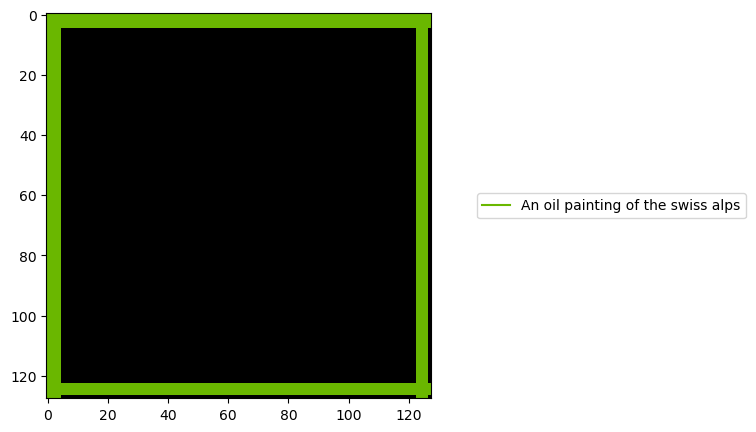

In [12]:
guidance_mag = 20.0

# Specify the locations of textual descriptions to compose
# The keys have the form (scale, x, y) where scale is the size of the canvas and x, y is the starting locations

# context = {
#     (2, 0, 0): {
#         'string': 'An epic space battle',
#         'magnitude': guidance_mag
#     },
#     (1, 0, 0): {
#         'string': 'The starship Enterprise',
#         'magnitude': guidance_mag
#     },
#     # (1, 64, 64): {
#     #     'string': 'A star destroyer from Star Wars',
#     #     'magnitude': guidance_mag
#     # },
# }

context = {
    (2, 0, 0): {
        'string': "An oil painting of the swiss alps",
        'magnitude': guidance_mag
    },
    # (1, 0, 0): {
    #     # 'string': "An oil painting of a quaint cottage",
    #     'string': "A quaint cottage in the style of an oil painting",
    #     'magnitude': guidance_mag
    # },
    # (1, 64, 64): {
    #     # "string": "An oil painting of a german shepherd",
    #     "string": "A german shepherd dog in the style of an oil painting",
    #     "magnitude": guidance_mag
    # }
}

# context = {
#     (2, 0, 0):{'string':'A fantasy landscape, wallpaper, concept art, extremely detailed', 'magnitude':guidance_mag},
#     (1, 60, 60):{'string':'a blue lake, fantasy, wallpaper, extremely detailed', 'magnitude':guidance_mag},
#     (1, 20, 20):{'string':'A fancy castle, fantasy, wallpaper, extremely detailed', 'magnitude':guidance_mag},
# }

color_lookup = {}
np.random.seed(1)
for k, v in context.items():
    color_lookup[v['string']] = (np.random.uniform(size=(3, )), k[0]**2)

plt.figure(figsize=(5, 5))
img = visualize_context(128, 64, context, color_lookup)

plt.imshow(img)

for k, v in context.items():
    scale, xstart, ystart = k
    caption = v['string']
    color = color_lookup[caption][0]
    plt.plot([], [], color=color, label=caption)

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.savefig('composite_captions.pdf', bbox_inches='tight')
plt.savefig('composite_captions.png', bbox_inches='tight', facecolor=plt.gca().get_facecolor())
# %download_file composite_captions.pdf
# %download_file composite_captions.png

In [14]:
has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')
print(device)

# initialize model
stage_1 = IFPipeline.from_pretrained("DeepFloyd/IF-I-XL-v1.0",
                                     variant="fp16",
                                     torch_dtype=torch.float16,
                                     use_auth_token=True)
stage_1.enable_xformers_memory_efficient_attention()
stage_1.enable_model_cpu_offload()
stage_1.safety_checker = None

# stage_2 = DiffusionPipeline.from_pretrained("DeepFloyd/IF-II-L-v1.0", text_encoder=None, variant="fp16", torch_dtype=torch.float16, use_auth_token=True)
# stage_2.enable_model_cpu_offload()
# stage_1.scheduler = DDIMScheduler.from_config(stage_1.scheduler.config)

cuda



A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.
Keyword arguments {'use_auth_token': True} are not expected by IFPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
num_steps = 1000

# increase the number of Langevin MCMC steps run to sample between intermediate distributions
# more steps improves sampling quality
# la_steps = 10
# la_steps = 15
la_steps = 20

la_step_sizes = stage_1.scheduler.betas * 2

alphas = 1 - stage_1.scheduler.betas
alphas_cumprod = np.cumprod(alphas)
scalar = np.sqrt(1 / (1 - alphas_cumprod))

la_sampler = AnnealedULASampler(num_steps, la_steps, la_step_sizes, None, None, None)

In [17]:
# import torch as th
# from IPython.display import display

seed = 0
# Number of intermediate transition distributions to specify
steps = 100

generator = torch.Generator('cuda').manual_seed(seed)

with torch.no_grad():
    latents = stage_1(context,
                      la_sampler,
                      height=128,
                      width=128,
                      generator=generator,
                      num_inference_steps=steps)


Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...



Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...


  0%|          | 0/100 [00:00<?, ?it/s]

/home/dcolli23/miniconda3/envs/compose_ebm_torch/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987277512/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [26]:
image = latents[0].cpu().numpy().transpose(1, 2, 0)
image = ((image + 1) / 2 * 255)

print(image.max())
print(image.min())

SHOW_CHANNELWISE_IMAGE = False
if SHOW_CHANNELWISE_IMAGE:
    plt.figure()
    plt.imshow(image[..., 0])

    plt.figure()
    plt.imshow(image[..., 1])

    plt.figure()
    plt.imshow(image[..., 2])

254.99948
-1.6801482


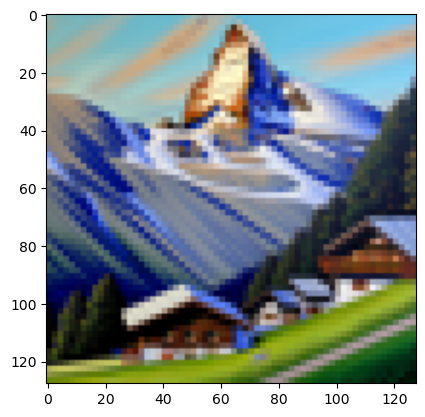

In [19]:
import matplotlib.pyplot as plt
# from imageio import imwrite

image = latents[0].cpu().numpy().transpose(1, 2, 0)
image = ((image + 1) / 2 * 255)

CLIP_DYNAMIC_RANGE = True
if CLIP_DYNAMIC_RANGE:
    image[image < 0.0] = 0.0
    image[image > 255] = 255

image = image.astype(np.uint8)
# imwrite("test.png", image)
plt.imshow(image)

In [22]:
stage_2 = DiffusionPipeline.from_pretrained("DeepFloyd/IF-II-L-v1.0",
                                            text_encoder=None,
                                            variant="fp16",
                                            torch_dtype=torch.float16)
stage_2.enable_xformers_memory_efficient_attention()
stage_2.enable_model_cpu_offload()


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [23]:
# This is changed from the original notebook. They were conditioning the stage 2 diffusion of
# DeepFloyd on an empty string which seems a bit ridiculous to me. As an intermediate stage, I'm
# conditioning Stage 2 on the first context's string.
# prompt = ""
prompt = context[(2, 0, 0)]["string"]
prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt)
images = stage_2(image=latents,
                 prompt_embeds=prompt_embeds,
                 negative_prompt_embeds=negative_embeds,
                 generator=generator,
                 output_type="pt").images


  0%|          | 0/50 [00:00<?, ?it/s]

0.0
255.0


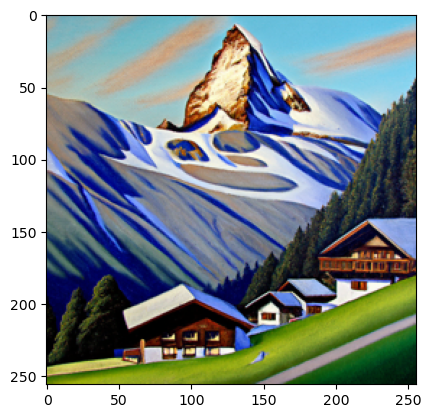

In [24]:
# save upsampled image
if not isinstance(images, np.ndarray):
    images = images[0].cpu().numpy().transpose(1, 2, 0)
    images = ((images + 1) / 2 * 255)

if CLIP_DYNAMIC_RANGE:
    images[images < 0.0] = 0.0
    images[images > 255] = 255

print(images.min())
print(images.max())

images = images.astype(np.uint8)
plt.imshow(images)

In [25]:
# np.save("oil_painting_swiss_alps_no_composed_diffusion_2.npy", images)